# Moral Foundations Scoring by LLMs

In [1]:
# Use 'haidt_political.py' to generate all of the .pkl files needed to run these cells
# TODOs: make sure to change base_folder variable (determining lm, generative vs scroing) on where you want to save all files for both notebook and python script

base_folder = "generative_gpt3/"

In [2]:
# Import Moral Foundations Utils
import sys
import os 
parent_directory =  os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
from utils.questionnaire_utils import *

# Visualization Imports 
import seaborn as sns
import pylab as plot
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
import pickle 
import pandas as pd
import torch
from sklearn import manifold

sns.set_style("ticks")
sns.set_palette(sns.color_palette("bright", 11))
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
params = {'legend.fontsize': 12}
plot.rcParams.update(params)
plt.rc('xtick',labelsize=17)
plt.rc('ytick',labelsize=17)

/Users/marwa_abdulhai/Desktop/BAIR/negotiation_project/haidt/google_share/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Human Study Scores

In [3]:
anon_haidt_paper_scores_liberal = {"Authority": 2.2, "Purity": 2.2, "Ingroup":  2.5, "Harm": 4.25, "Fairness": 4.35}
anon_haidt_paper_scores_moderate = {"Authority": 2.8, "Purity": 3.0, "Ingroup":  3.0, "Harm": 4.0, "Fairness": 3.95}
anon_haidt_paper_scores_conservative = {"Authority": 3.1, "Purity": 3.4 , "Ingroup":  3.12, "Harm": 3.5, "Fairness": 3.65}

us_haidt_paper_scores_liberal = {"Authority": 1.9, "Purity": 1.2, "Ingroup":  2.05, "Harm": 3.6, "Fairness": 3.75}
us_haidt_paper_scores_moderate = {"Authority": 2.65, "Purity": 2.2, "Ingroup":  2.65, "Harm": 3.4, "Fairness": 3.45}
us_haidt_paper_scores_conservative = {"Authority": 3.5, "Purity": 3.1 , "Ingroup":  3.4, "Harm": 3.0, "Fairness": 3.1}

korean_haidt_paper_scores_liberal = {"Authority": 2.25, "Purity": 2.4, "Ingroup":  2.3, "Harm": 3.35, "Fairness": 3.5}
korean_haidt_paper_scores_moderate = {"Authority": 2.55, "Purity": 2.65, "Ingroup":  2.65, "Harm": 3.25, "Fairness": 3.35}
korean_haidt_paper_scores_conservative = {"Authority": 2.9, "Purity": 2.75 , "Ingroup":  2.8, "Harm": 3.35, "Fairness": 3.1}

# Reading in All Data

In [4]:
engines = ["text-davinci-003", "text-davinci-002", "text-babbage-001", "text-curie-001"] # TODO: add LM here 
prompts = ['noprompt', 'liberal', 'moderate', 'conservative']
human_studies =["anon", "us", "korea"]
human_prompts = ['liberal', 'moderate', 'conservative']
value_labels = ["Harm", "Fairness", "Ingroup", "Authority", "Purity"]
def return_haidt_foundations(file):
    with open(base_folder + file, 'rb') as f:
        data = pickle.load(f)

    x = [[int(float(j)) for j in i] for i in data]

    answers_mean = torch.mode(torch.tensor(x).to(torch.float64), dim=1)[0]
    answers_std = torch.mode(torch.tensor(x).to(torch.float64), dim=1)[1]

    values_avg = compute_mfq(answers_mean)
    values_dict = {value_labels[value]:values_avg[value].item() for value in range(len(value_labels))}
    returned_scores = [i.item() for i in values_avg[:5]]
    return returned_scores

def difference_llm_human_engines(engine, prompt, all_saved_data, human_study_scores):
    llm_scores = all_saved_data[engine + "_" + prompt]
    difference_avg = 0
    for i in range(len(value_labels)):
        difference_avg += abs(llm_scores[i] - human_study_scores[value_labels[i]])
    return difference_avg

def plot_llm_foundations(values, legend_label):
    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, value in enumerate(['Harm', 'Fairness', 'Ingroup', 'Authority', 'Purity']):
        ax.plot(range(0,4), [values[j][i] for j in range(len(values))], 'o-', color=colors[i], label=value+"-" + legend_label)

    ax.legend(loc='best', fancybox=True, shadow=True)
    plt.ylabel("MFQ Scores", size=12)
    plt.xlabel("Prompts", size=12)
    plt.xticks(range(0,4), labels=["Liberal Prompt", "Moderate Prompt", "Default (no prompt)", "Conservative Prompt"], size=9)
    plt.ylim([0,5])
    
def plot_human_foundations(values, legend_label):
    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, value in enumerate(['Harm', 'Fairness', 'Ingroup', 'Authority', 'Purity']):
        ax.plot(range(0,3), [real_values[j][value] for j in range(len(values))], 'o--', label=value+"-Human", color=colors[i])

    ax.legend(loc='best', fancybox=True, shadow=True)
    plt.ylabel("MFQ Scores", size=12)
    plt.xlabel("Political Identity", size=12)
    plt.xticks(range(0,3), labels=["Liberal", "Moderate", "Conservative"], size=12)
    plt.ylim([0,5]) 

In [5]:
# Load all data
files = ['text-davinci-003/engine_text-davinci-003_prompt_.pkl',
         'text-davinci-003/engine_text-davinci-003_prompt_Youarepoliticallyliberal..pkl',
         'text-davinci-003/engine_text-davinci-003_prompt_Youarepoliticallymoderate..pkl',
         'text-davinci-003/engine_text-davinci-003_prompt_Youarepoliticallyconservative..pkl',
         'text-davinci-002/engine_text-davinci-002_prompt_.pkl',
         'text-davinci-002/engine_text-davinci-002_prompt_Youarepoliticallyliberal..pkl',
         'text-davinci-002/engine_text-davinci-002_prompt_Youarepoliticallymoderate..pkl',
         'text-davinci-002/engine_text-davinci-002_prompt_Youarepoliticallyconservative..pkl', 
         'text-babbage-001/engine_text-babbage-001_prompt_.pkl', 
         'text-babbage-001/engine_text-babbage-001_prompt_Youarepoliticallyliberal..pkl',
         'text-babbage-001/engine_text-babbage-001_prompt_Youarepoliticallymoderate..pkl',
         'text-babbage-001/engine_text-babbage-001_prompt_Youarepoliticallyconservative..pkl',
         'text-curie-001/engine_text-curie-001_prompt_.pkl', 
         'text-curie-001/engine_text-curie-001_prompt_Youarepoliticallyliberal..pkl',
         'text-curie-001/engine_text-curie-001_prompt_Youarepoliticallymoderate..pkl',
         'text-curie-001/engine_text-curie-001_prompt_Youarepoliticallyconservative..pkl']

all_saved_data = {}
engine_count = 0
prompt_count = 0
for i in range(len(files)):
    if i!=0 and i%len(engines) == 0:
        engine_count+=1
    if i!=0 and i%len(prompts)==0:
        prompt_count=0
    all_saved_data[engines[engine_count] + "_" + prompts[prompt_count]] = return_haidt_foundations(files[i])
    prompt_count+=1

## Plotting Moral Foundations of Davinci-002 across political affiliation 

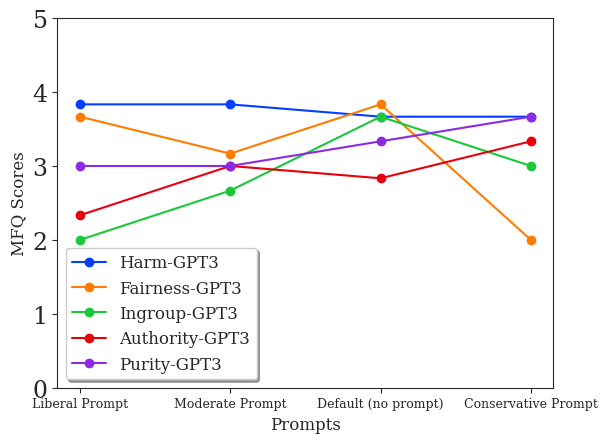

In [8]:
engine = 'text-davinci-002' # set engine
prompts = ['liberal', 'moderate', 'noprompt', 'conservative']
values = [all_saved_data[engine + "_" + prompt] for prompt in prompts]
plot_llm_foundations(values, legend_label='GPT3')

## Plotting Moral Foundations from Anonymous Human Study across political affiliation 

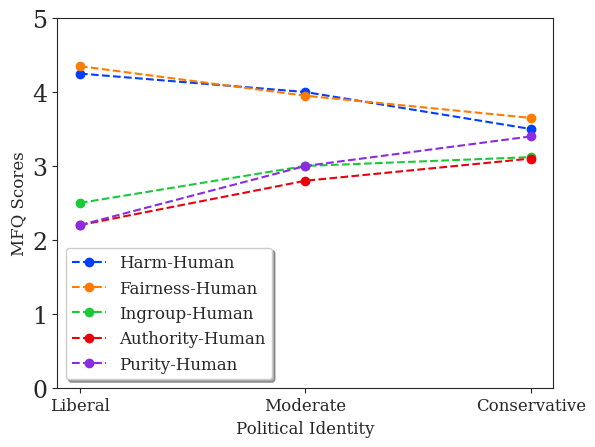

In [9]:
real_values = [anon_haidt_paper_scores_liberal, anon_haidt_paper_scores_moderate, anon_haidt_paper_scores_conservative]
plot_human_foundations(real_values, legend_label='Human')

## Plotting Moral Foundations from Korean Human Study across political affiliation 

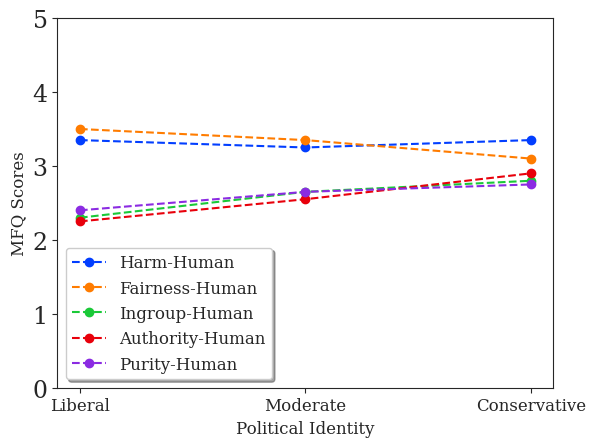

In [10]:
real_values = [korean_haidt_paper_scores_liberal, korean_haidt_paper_scores_moderate, korean_haidt_paper_scores_conservative]
plot_human_foundations(real_values, legend_label='Human')

# Difference across LLM and Country with No Prompting

In [11]:
anon_scores = [anon_haidt_paper_scores_liberal, anon_haidt_paper_scores_moderate, anon_haidt_paper_scores_conservative]
us_scores = [us_haidt_paper_scores_liberal, us_haidt_paper_scores_moderate, us_haidt_paper_scores_conservative]
korean_scores = [korean_haidt_paper_scores_liberal, korean_haidt_paper_scores_moderate, korean_haidt_paper_scores_conservative]
human_studies_scores = [anon_scores, us_scores, korean_scores]
for engine in engines: 
    print(engine)
    print("_________________________________________")
    for i in range(len(human_studies_scores)):
        human = human_studies[i]
        human_scores = human_studies_scores[i]
        for j in range(len(human_scores)):
            prompt ='noprompt'
            human_score = human_scores[j]
            label = human_prompts[j]
            difference = difference_llm_human_engines(engine, prompt, all_saved_data, human_score)
            print("for:", engine, "prompt:", prompt, "human:", human, "label:", label, "difference-->", difference)


text-davinci-003
_________________________________________
for: text-davinci-003 prompt: noprompt human: anon label: liberal difference--> 4.033333333333333
for: text-davinci-003 prompt: noprompt human: anon label: moderate difference--> 3.416666666666667
for: text-davinci-003 prompt: noprompt human: anon label: conservative difference--> 2.77
for: text-davinci-003 prompt: noprompt human: us label: liberal difference--> 3.8666666666666676
for: text-davinci-003 prompt: noprompt human: us label: moderate difference--> 2.6166666666666667
for: text-davinci-003 prompt: noprompt human: us label: conservative difference--> 2.9
for: text-davinci-003 prompt: noprompt human: korea label: liberal difference--> 1.833333333333334
for: text-davinci-003 prompt: noprompt human: korea label: moderate difference--> 1.8166666666666669
for: text-davinci-003 prompt: noprompt human: korea label: conservative difference--> 2.066666666666667
text-davinci-002
_________________________________________
for: text

# Differences across LLM, Country with Prompting

In [12]:
anon_scores = [anon_haidt_paper_scores_liberal, anon_haidt_paper_scores_moderate, anon_haidt_paper_scores_conservative]
us_scores = [us_haidt_paper_scores_liberal, us_haidt_paper_scores_moderate, us_haidt_paper_scores_conservative]
korean_scores = [korean_haidt_paper_scores_liberal, korean_haidt_paper_scores_moderate, korean_haidt_paper_scores_conservative]
human_studies =["anon", "us", "korea"]
human_studies_scores = [anon_scores, us_scores, korean_scores]
for engine in engines: 
    print("_________________________________________")
    for i in range(len(human_studies_scores)):
        human = human_studies[i]
        human_scores = human_studies_scores[i]
        for j in range(len(human_prompts)):
            prompt = human_prompts[j]
            difference = difference_llm_human_engines(engine, prompt, all_saved_data, human_scores[i])
            print("for:", engine, "prompt:", prompt, "human:", human, "difference-->", difference)


_________________________________________
for: text-davinci-003 prompt: liberal human: anon difference--> 3.4333333333333336
for: text-davinci-003 prompt: moderate human: anon difference--> 3.933333333333333
for: text-davinci-003 prompt: conservative human: anon difference--> 5.033333333333333
for: text-davinci-003 prompt: liberal human: us difference--> 2.2833333333333337
for: text-davinci-003 prompt: moderate human: us difference--> 2.783333333333333
for: text-davinci-003 prompt: conservative human: us difference--> 3.6166666666666663
for: text-davinci-003 prompt: liberal human: korea difference--> 1.8666666666666667
for: text-davinci-003 prompt: moderate human: korea difference--> 2.2333333333333334
for: text-davinci-003 prompt: conservative human: korea difference--> 3.0666666666666664
_________________________________________
for: text-davinci-002 prompt: liberal human: anon difference--> 2.5333333333333328
for: text-davinci-002 prompt: moderate human: anon difference--> 3.3666666

## Visualization of Scores across LLM, Country, and Political Affilitation

In [13]:
countries = ["Anon", "US-American", "Korean"]
_ALL_COMBINATIONS_countries = [country + "-" + category for country in human_studies for category in human_prompts]
_ALL_COMBINATIONS_lms = [lm + "-" + category for lm in engines for category in prompts]
all_country_data = [list(anon_haidt_paper_scores_liberal.values()), list(anon_haidt_paper_scores_moderate.values()), list(anon_haidt_paper_scores_conservative.values()),
                   list(us_haidt_paper_scores_liberal.values()), list(us_haidt_paper_scores_moderate.values()), list(us_haidt_paper_scores_conservative.values()), 
                   list(korean_haidt_paper_scores_liberal.values()), list(korean_haidt_paper_scores_moderate.values()), list(korean_haidt_paper_scores_conservative.values())]

all_lm_data = []
for lm in engines:
    for category in prompts:
        all_lm_data.append(all_saved_data[lm + "_" + category])
        
df = pd.DataFrame({
    'respondent': _ALL_COMBINATIONS_countries + _ALL_COMBINATIONS_lms ,
    'respondent_type': ['country'] * len(_ALL_COMBINATIONS_countries) + ['LM'] * len(_ALL_COMBINATIONS_lms),
    'response': all_country_data + all_lm_data,
})


## PCA Results

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = np.vstack(df['response'])
Xt = pca.fit_transform(X)
df['PCA Dimension 1'], df['PCA Dimension 2'] = Xt[:,0], Xt[:,1]
df.head()

,respondent,respondent_type,response,PCA Dimension 1,PCA Dimension 2
0,anon-liberal,country,"[2.2, 2.2, 2.5, 4.25, 4.35]",-0.531764,1.726083
1,anon-moderate,country,"[2.8, 3.0, 3.0, 4.0, 3.95]",-1.053376,0.788847
2,anon-conservative,country,"[3.1, 3.4, 3.12, 3.5, 3.65]",-1.106163,0.048205
3,us-liberal,country,"[1.9, 1.2, 2.05, 3.6, 3.75]",0.694911,1.733985
4,us-moderate,country,"[2.65, 2.2, 2.65, 3.4, 3.45]",-0.093381,0.704897


In [15]:
def color_mapping(row):
    if row.respondent_type == 'country':
        return 'country'
    elif row.respondent.find("flan")!=-1:
        return 'PaLM'
    elif row.respondent.find("davinci-003")!=-1:
        return 'davinci003'
    elif row.respondent.find("davinci-002")!=-1:
        return 'davinci002'
    elif row.respondent.find("babbage")!=-1:
        return 'babbage'
    elif row.respondent.find("curie")!=-1:
        return 'curie'
  
df['respondent_type'] = df.apply(color_mapping, axis=1)

def name_mapping(row):
    print(row.respondent)
    index_flan = row.respondent.find("-")
    flan_index = row.respondent.find("flan")
    if index_flan!=-1 and flan_index!=-1:
        return "PaLM-" + row.respondent[index_flan+1:]
    else:
        return row.respondent
    
df['respondent'] = df.apply(name_mapping, axis=1)



anon-liberal
anon-moderate
anon-conservative
us-liberal
us-moderate
us-conservative
korea-liberal
korea-moderate
korea-conservative
text-davinci-003-liberal
text-davinci-003-moderate
text-davinci-003-noprompt
text-davinci-003-conservative
text-davinci-002-liberal
text-davinci-002-moderate
text-davinci-002-noprompt
text-davinci-002-conservative
text-babbage-001-liberal
text-babbage-001-moderate
text-babbage-001-noprompt
text-babbage-001-conservative
text-curie-001-liberal
text-curie-001-moderate
text-curie-001-noprompt
text-curie-001-conservative
flan_palm_62b_q1-liberal
flan_palm_62b_q1-moderate
flan_palm_62b_q1-noprompt
flan_palm_62b_q1-conservative


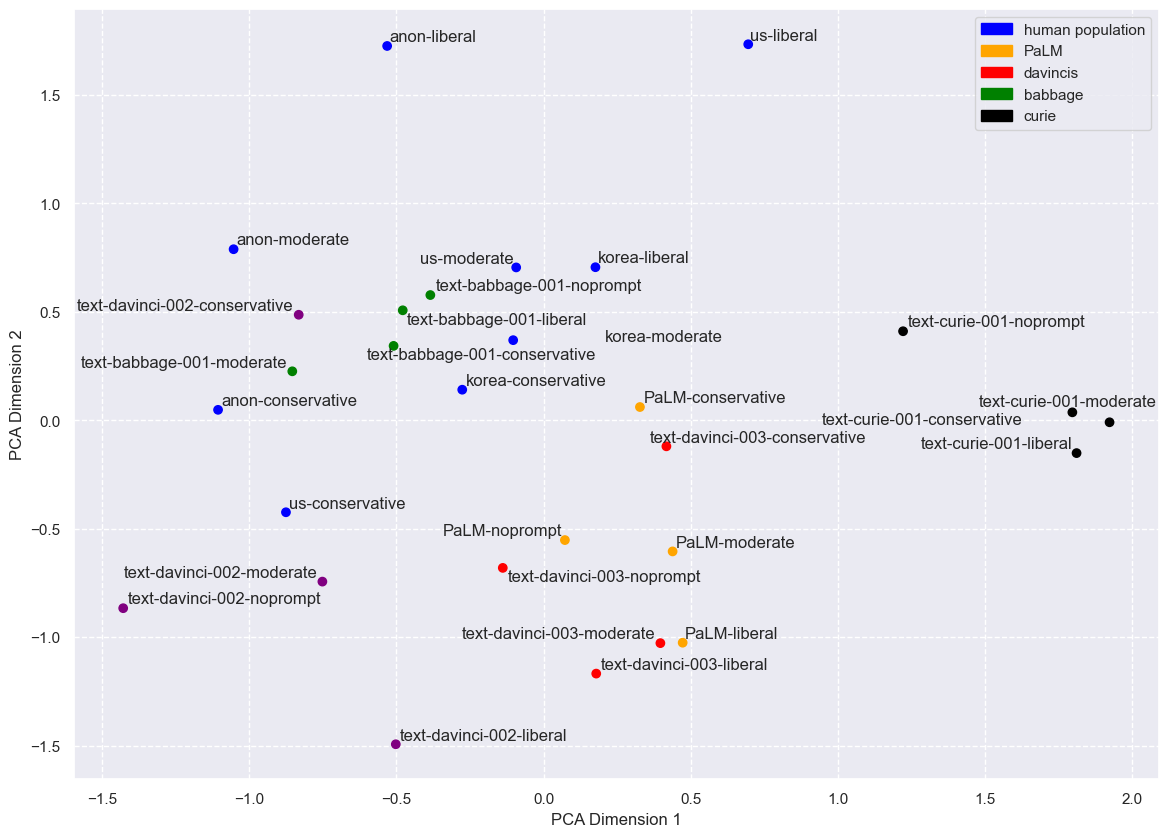

In [16]:
import seaborn as sns; sns.set()
from adjustText import adjust_text
import matplotlib.patches as mpatches

fig, ax = plt.subplots()
plt.grid(True, linestyle='--')        
fig.set_figwidth(14)
fig.set_figheight(10)
colors = {'country':'blue', 'PaLM':'orange', 'davinci003': 'red', 'davinci002': 'purple', 'babbage':'green', 'curie': 'black'}
plt.xlabel('PCA Dimension 1', size = 12)
plt.ylabel('PCA Dimension 2', size = 12)
ax.scatter(df['PCA Dimension 1'], df['PCA Dimension 2'], c=df['respondent_type'].map(colors))

texts = [plt.text(df["PCA Dimension 1"][i], df["PCA Dimension 2"][i], df['respondent'][i]) for i in range(len(df))]
adjust_text(texts)
blue_patch = mpatches.Patch(color='blue', label='human population')
orange_patch = mpatches.Patch(color='orange', label='PaLM')
red_patch = mpatches.Patch(color='red', label='davincis')
green_patch = mpatches.Patch(color='green', label='babbage')
black_patch = mpatches.Patch(color='black', label='curie')

plt.legend(handles=[blue_patch, orange_patch, red_patch, green_patch, black_patch])

plt.show()


## TSNE Results

In [17]:
perplexity_val = len(df)**(1/2) 
print(perplexity_val)
df['X'], df['Y'] = zip(*manifold.TSNE(n_components=2, perplexity=perplexity_val).fit_transform(np.vstack(df['response'])))
df.head()
(len(df))

5.385164807134504


/Users/marwa_abdulhai/Desktop/BAIR/negotiation_project/haidt/google_share/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/marwa_abdulhai/Desktop/BAIR/negotiation_project/haidt/google_share/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


29

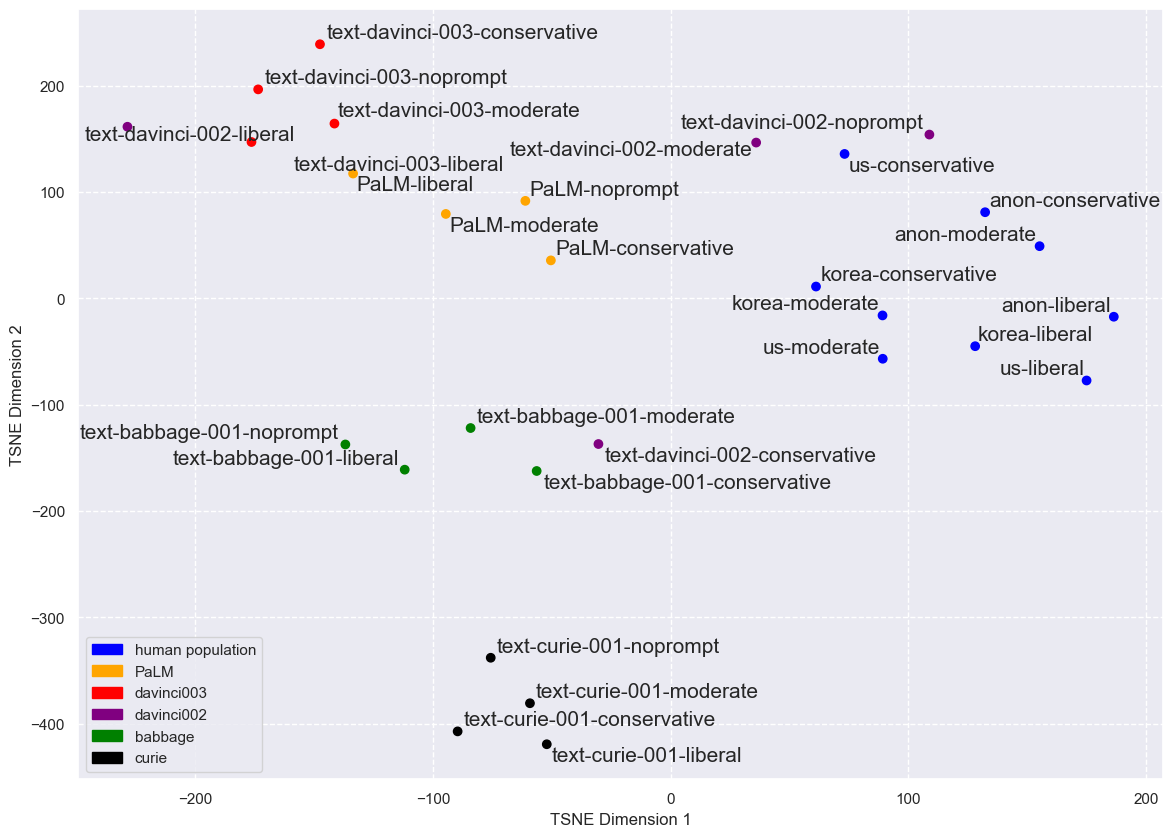

In [18]:
import seaborn as sns; sns.set()
from adjustText import adjust_text
import matplotlib.patches as mpatches
import random
random.seed(1)

fig, ax = plt.subplots()
plt.grid(True, linestyle='--')        
fig.set_figwidth(14)
fig.set_figheight(10)
colors = {'country':'blue', 'PaLM':'orange', 'davinci003': 'red', 'davinci002': 'purple', 'babbage':'green', 'curie': 'black'}
plt.xlabel('TSNE Dimension 1', size = 12)
plt.ylabel('TSNE Dimension 2', size = 12)
ax.scatter(df['X'], df['Y'], c=df['respondent_type'].map(colors))

texts = [plt.text(df["X"][i], df["Y"][i], df['respondent'][i],size=15) for i in range(len(df))]
adjust_text(texts)
blue_patch = mpatches.Patch(color='blue', label='human population')
orange_patch = mpatches.Patch(color='orange', label='PaLM')
red_patch = mpatches.Patch(color='red', label='davinci003')
purple_patch = mpatches.Patch(color='purple', label='davinci002')
green_patch = mpatches.Patch(color='green', label='babbage')
black_patch = mpatches.Patch(color='black', label='curie')

plt.legend(handles=[blue_patch, orange_patch, red_patch, purple_patch, green_patch, black_patch], loc='lower left')

plt.show()

